# EDA file supercon2_v22.12.03.csv

>>> BẮT ĐẦU EDA DỮ LIỆU SUPERCON GỐC (NIMS)...
 Đã load file. Tổng số dòng: 40324, Số cột: 23

--- 1. TỔNG QUAN DỮ LIỆU ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40324 entries, 0 to 40323
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    40324 non-null  object 
 1   rawMaterial                           40324 non-null  object 
 2   materialId                            39998 non-null  float64
 3   name                                  7277 non-null   object 
 4   formula                               29320 non-null  object 
 5   doping                                5095 non-null   object 
 6   shape                                 4470 non-null   object 
 7   materialClass                         26913 non-null  object 
 8   fabrication                           203 non-null    object 
 9   substrate                

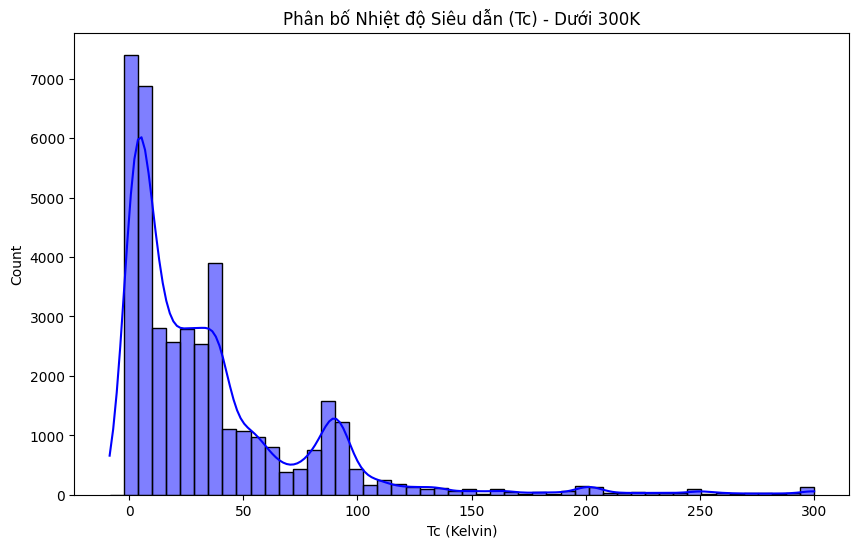


--- 4. PHÂN TÍCH ÁP SUẤT (PRESSURE) ---
Tổng số dòng có ghi Áp suất: 2052

>> Top 20 giá trị Áp suất thường gặp nhất (Raw text):
appliedPressure
ambient pressure    507
200 GPa              56
150 GPa              47
3 GPa                36
4 GPa                34
2.5 GPa              31
2 GPa                31
155 GPa              29
250 GPa              27
1 GPa                25
30 GPa               24
0 GPa                23
10 GPa               20
8 GPa                19
7 GPa                18
20 GPa               18
300 GPa              17
1.6 GPa              15
5 GPa                14
9 GPa                14
Name: count, dtype: int64

>> Số lượng mẫu Áp suất cao (> 1 GPa): 1253
>> Top 5 mẫu Áp suất cao nhất:
      appliedPressure  P_Float        formula
26350         539 GPa    539.0            NaN
10145         500 GPa    500.0            NaN
29341         500 GPa    500.0            NaN
13025          500GPa    500.0            NaN
22534         500 GPa    500.0  F m 3m-Li 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình hiển thị cho đẹp
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 1000)

print(">>> BẮT ĐẦU EDA DỮ LIỆU SUPERCON GỐC (NIMS)...")

# 1. Load dữ liệu
file_path = "../data/data_NIMS/supercon2_v22.12.03.csv" # Đường dẫn tới file dữ liệu gốc
try:
    df = pd.read_csv(file_path)
    print(f" Đã load file. Tổng số dòng: {df.shape[0]}, Số cột: {df.shape[1]}")
except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file. Kiểm tra lại tên file.")
    exit()

# --------------------------------------------------------------------------------
# PHẦN 1: KIỂM TRA SỨC KHỎE TỔNG QUÁT
# --------------------------------------------------------------------------------
print("\n--- 1. TỔNG QUAN DỮ LIỆU ---")
print(df.info())

print("\n--- 2. KIỂM TRA DỮ LIỆU BỊ THIẾU (MISSING) ---")
missing = df[['formula', 'name', 'criticalTemperature', 'appliedPressure', 'rawMaterial']].isnull().sum()
print(missing)
print(f"-> Tỷ lệ thiếu Formula: {missing['formula']/len(df)*100:.2f}%")
print(f"-> Tỷ lệ thiếu Áp suất (Pressure): {missing['appliedPressure']/len(df)*100:.2f}%")

# --------------------------------------------------------------------------------
# PHẦN 2: SOI CỘT NHIỆT ĐỘ (Tc) - TÌM KẺ ĐIÊN 5000K
# --------------------------------------------------------------------------------
print("\n--- 3. PHÂN TÍCH NHIỆT ĐỘ (Tc) ---")

# Hàm trích xuất số từ chuỗi Tc (để vẽ biểu đồ)
def extract_tc(val):
    if pd.isna(val): return None
    # Tìm tất cả các số
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", str(val))
    if nums:
        return float(nums[0]) # Lấy số đầu tiên
    return None

# Tạo cột tạm để soi
df['Tc_Float'] = df['criticalTemperature'].apply(extract_tc)

print(">> Top 10 giá trị Tc cao nhất (Xem có ảo không):")
print(df[['criticalTemperature', 'Tc_Float', 'formula', 'name']].sort_values(by='Tc_Float', ascending=False).head(10))

print(f"\n>> Số lượng mẫu có Tc > 300 K (Hàng ảo): {len(df[df['Tc_Float'] > 300])}")
print(f">> Số lượng mẫu có Tc hợp lý (0 - 300 K): {len(df[(df['Tc_Float'] >= 0) & (df['Tc_Float'] <= 300)])}")

# Vẽ biểu đồ phân bố Tc (Chỉ vẽ đám < 300K cho dễ nhìn)
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Tc_Float'] <= 300]['Tc_Float'], bins=50, kde=True, color='blue')
plt.title('Phân bố Nhiệt độ Siêu dẫn (Tc) - Dưới 300K')
plt.xlabel('Tc (Kelvin)')
plt.show()

# --------------------------------------------------------------------------------
# PHẦN 3: SOI CỘT ÁP SUẤT (PRESSURE) - TÌM HÀNG HIẾM
# --------------------------------------------------------------------------------
print("\n--- 4. PHÂN TÍCH ÁP SUẤT (PRESSURE) ---")

# Lọc những dòng CÓ thông tin áp suất
df_press = df[df['appliedPressure'].notna()]
print(f"Tổng số dòng có ghi Áp suất: {len(df_press)}")

print("\n>> Top 20 giá trị Áp suất thường gặp nhất (Raw text):")
print(df_press['appliedPressure'].value_counts().head(20))

# Hàm trích xuất GPa sơ bộ để soi
def extract_pressure(val):
    if pd.isna(val): return 0.0
    val_str = str(val).lower()
    if 'ambient' in val_str: return 0.0
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", val_str)
    if not nums: return 0.0
    num = float(nums[0])
    # Quy đổi sơ sơ
    if 'gpa' in val_str: return num
    elif 'kbar' in val_str: return num / 10.0
    return num # Mặc định coi là GPa nếu số to

df['P_Float'] = df['appliedPressure'].apply(extract_pressure)

print(f"\n>> Số lượng mẫu Áp suất cao (> 1 GPa): {len(df[df['P_Float'] > 1])}")
print(">> Top 5 mẫu Áp suất cao nhất:")
print(df[['appliedPressure', 'P_Float', 'formula']].sort_values(by='P_Float', ascending=False).head(5))

# --------------------------------------------------------------------------------
# PHẦN 4: TRUY TÌM CÔNG THỨC BỊ MẤT & CHẤT NỔI TIẾNG (LaH10, H3S)
# --------------------------------------------------------------------------------
print("\n--- 5. KIỂM TRA CHẤT CỤ THỂ (LaH10, H3S) ---")

targets = ['LaH10', 'H3S']
for t in targets:
    print(f"\n>>> Soi chất: {t}")
    # Tìm trong cả formula, name và rawMaterial
    mask = (
        df['formula'].astype(str).str.contains(t, case=False, na=False) |
        df['name'].astype(str).str.contains(t, case=False, na=False) |
        df['rawMaterial'].astype(str).str.contains(t, case=False, na=False)
    )
    subset = df[mask]
    print(f"   -> Tìm thấy: {len(subset)} dòng")
    if not subset.empty:
        print("   -> 5 dòng đầu tiên:")
        print(subset[['id', 'formula', 'criticalTemperature', 'appliedPressure', 'rawMaterial']].head(5))
    else:
        print("   -> Không thấy tăm hơi đâu.")

print("\n>>> KẾT THÚC EDA DỮ LIỆU SUPERCON GỐC (NIMS).")

# eda dataset sau khi xử lí

>>> BẮT ĐẦU KIỂM TRA CHẤT LƯỢNG DATASET LẦN CUỐI...
 Đã load file. Tổng số dòng: 24858

--- 1. THỐNG KÊ CƠ BẢN ---
           Tc_Clean  Pressure_GPa
count  24858.000000  24858.000000
mean      34.922583      3.256603
std       38.602754     23.726905
min        0.000000      0.000000
25%        5.800000      0.000000
50%       23.000000      0.000000
75%       50.000000      0.000000
max      300.000000    450.000000

--- 2. KIỂM TRA ĐIỀU KIỆN 'SIÊU TƯỞNG' (PHYSICS CHECK) ---
 TUYỆT VỜI: Không có chất nào vi phạm luật vật lý (P~0, Tc>145K).

--- 3. KIỂM TRA CÁC CHẤT NHẠY CẢM ---
MgB2 - Max Tc: 42.0 K (Kỳ vọng: < 45K)
LaH10 - Min Pressure: 150.0 GPa (Kỳ vọng: > 100 GPa)
H3S - Min Pressure: 150.0 GPa (Kỳ vọng: > 100 GPa)

--- 4. VẼ BIỂU ĐỒ PHÂN BỐ ---


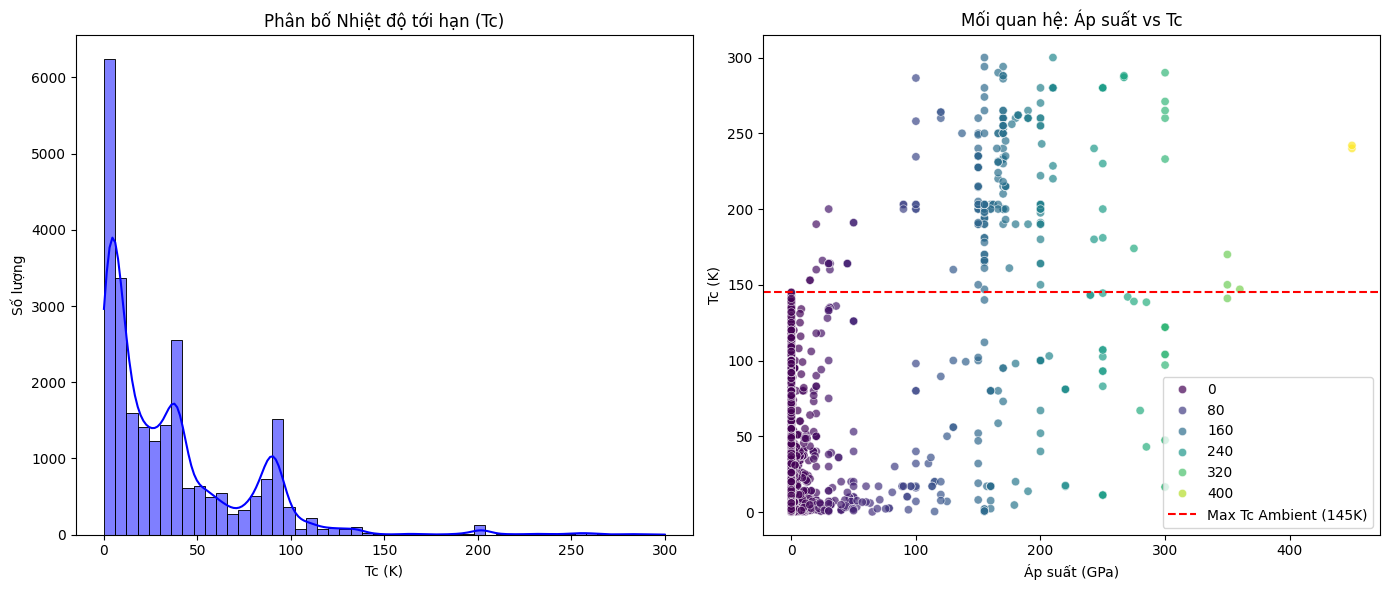


>>> KẾT LUẬN: Nếu biểu đồ đẹp và không có cảnh báo đỏ, DATASET NÀY LÀ CHUẨN.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(">>> BẮT ĐẦU KIỂM TRA CHẤT LƯỢNG DATASET LẦN CUỐI...")

# 1. Load file
try:
    df = pd.read_csv("../data/data_final/SuperCon_Expert_Fixed_final.csv")
    print(f" Đã load file. Tổng số dòng: {len(df)}")
except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file 'SuperCon_Expert_Fixed_final.csv'")
    exit()

# -------------------------------------------------------------------------
# PHẦN 1: KIỂM TRA CÁC CHỈ SỐ QUAN TRỌNG (KEY METRICS)
# -------------------------------------------------------------------------
print("\n--- 1. THỐNG KÊ CƠ BẢN ---")
print(df[['Tc_Clean', 'Pressure_GPa']].describe())

# -------------------------------------------------------------------------
# PHẦN 2: SĂN LÙNG RÁC (GARBAGE HUNTING)
# -------------------------------------------------------------------------
print("\n--- 2. KIỂM TRA ĐIỀU KIỆN 'SIÊU TƯỞNG' (PHYSICS CHECK) ---")
# Luật: Ở áp suất thường (< 1 GPa), không được có Tc > 145 K.
garbage = df[(df['Pressure_GPa'] < 1.0) & (df['Tc_Clean'] > 145.0)]

if len(garbage) == 0:
    print(" TUYỆT VỜI: Không có chất nào vi phạm luật vật lý (P~0, Tc>145K).")
else:
    print(f" CẢNH BÁO: Vẫn còn {len(garbage)} dòng rác! (Cần xem lại ngay)")
    print(garbage[['Final_Formula', 'Tc_Clean', 'Pressure_GPa']].head())

# -------------------------------------------------------------------------
# PHẦN 3: KIỂM TRA CÁC 'NGÔI SAO' (STAR MATERIALS CHECK)
# -------------------------------------------------------------------------
print("\n--- 3. KIỂM TRA CÁC CHẤT NHẠY CẢM ---")

# MgB2 (Phải <= 45K)
mgb2 = df[df['Final_Formula'].astype(str).str.contains("MgB2", case=False)]
print(f"MgB2 - Max Tc: {mgb2['Tc_Clean'].max()} K (Kỳ vọng: < 45K)")

# LaH10 (Phải áp suất cao > 100 GPa)
lah10 = df[df['Final_Formula'].astype(str).str.contains("LaH10", case=False)]
print(f"LaH10 - Min Pressure: {lah10['Pressure_GPa'].min()} GPa (Kỳ vọng: > 100 GPa)")

# H3S (Phải áp suất cao)
h3s = df[df['Final_Formula'].astype(str).str.contains("H3S", case=False)]
print(f"H3S - Min Pressure: {h3s['Pressure_GPa'].min()} GPa (Kỳ vọng: > 100 GPa)")

# -------------------------------------------------------------------------
# PHẦN 4: VẼ BIỂU ĐỒ (VISUALIZATION)
# -------------------------------------------------------------------------
print("\n--- 4. VẼ BIỂU ĐỒ PHÂN BỐ ---")

plt.figure(figsize=(14, 6))

# Biểu đồ 1: Tc Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Tc_Clean'], bins=50, kde=True, color='blue')
plt.title("Phân bố Nhiệt độ tới hạn (Tc)")
plt.xlabel("Tc (K)")
plt.ylabel("Số lượng")

# Biểu đồ 2: Scatter Plot (Áp suất vs Tc)
# Tô màu những điểm áp suất cao để dễ nhìn
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Pressure_GPa', y='Tc_Clean', hue='Pressure_GPa', palette='viridis', alpha=0.7)
plt.title("Mối quan hệ: Áp suất vs Tc")
plt.xlabel("Áp suất (GPa)")
plt.ylabel("Tc (K)")
plt.axhline(y=145, color='r', linestyle='--', label='Max Tc Ambient (145K)')
plt.legend()

plt.tight_layout()
plt.show()

print("\n>>> KẾT LUẬN: Nếu biểu đồ đẹp và không có cảnh báo đỏ, DATASET NÀY LÀ CHUẨN.")